# Preprocessing — Overview

1. Setup — imports & environment
2. Database — load `historical_posts` and `historical_comments` from Oracle
3. Load tickers — load and normalize ticker list (NASDAQ + NYSE)
4. Data harmonization <br>
   4.1 Unify schema into `df_unified`<br>
   4.2 Placeholder-only rows analysis<br>
   4.3 Remove [removed]/[deleted] placeholders<br>
   4.4 Merge `title` + `body` for posts into `text`<br>
5. EDA — overview, missingness, text length, temporal analysis <br>
   5.1 Data types & schema overview<br>
   5.2 Column value distributions<br>
   5.3 Overview — counts & missingness<br>
   5.4 Text characteristics — word count histograms<br>
   5.5 Temporal analysis — day/hour distribution<br>
   5.6 Engagement metrics — upvote ratio<br>
   5.7 Integrity and duplicates — ID uniqueness<br>
6. Data Cleaning — remove invalid/empty records, deduplicate, drop unnecessary columns
7. Feature engineering — text_length, word_count, temporal features, engagement features, normalized_upvotes
8. Ticker detection <br>
   8.1 Detect `mentioned_tickers`, `n_tickers`<br>
   8.2 Filter false positive tickers using stopwords<br>
   8.3 Ticker inheritance — inherit parent post tickers to comments<br>
   8.4 Inheritance success check<br>
   8.5 Data Type Conversion<br>
9. Text normalization — minimal cleaning for FinBERT (remove URLs, normalize whitespace)
10. Export — convert mentioned_tickers to CSV-friendly string, export `preprocessed_data.csv`
11. Database Export — save to Oracle table `preprocessed_data`

**Output:** `preprocessed_data.csv` + Oracle table `preprocessed_data`

**Reddit API documentation (column descriptions):** https://praw.readthedocs.io/en/stable/code_overview/models/submission.html

**Recommended:** Install Data Wrangler extension by Microsoft for VS Code. It provides data quality metrics and lets you view/refresh DataFrames as you process data.

**Tip:** Use the OUTLINE view in the left sidebar for easy navigation through this notebook.

**Most functions are defined in `utils.py` and imported here.**

**ENJOY THE RUN**

## 1 Setup — Imports & environment

Load required libraries and verify Oracle database driver availability.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from dotenv import load_dotenv
load_dotenv()

import oracledb
from utils import (
    get_oracle_connection,
    get_all_us_tickers,
    apply_ticker_detection,
    load_ticker_stopwords,
    apply_ticker_stopword_filter,
    harmonize_schema,
    drop_invalid_texts,
    deduplicate_and_normalize_types,
    add_temporal_features,
    add_engagement_features,
    normalize_text_for_sentiment
)

MIN_TEXT_LENGTH = 10
print("Setup complete")

INFO:utils:spaCy model loaded successfully


Setup complete


## 2 Database — Load Posts & Comments

Connect to Oracle database and load posts and comments from `historical_posts` and `historical_comments` tables.

In [2]:
conn = get_oracle_connection()

if conn:
    query_posts = """
        SELECT author, title, created_utc, id, is_original_content, score,
               DBMS_LOB.SUBSTR(body, 4000, 1) as body, subreddit, upvote_ratio, url
        FROM historical_posts
        ORDER BY created_utc DESC
    """
    df_posts = pd.read_sql_query(query_posts, conn)

    query_comments = """
        SELECT author, created_utc, id, parent_post_id, score,
               DBMS_LOB.SUBSTR(body, 4000, 1) as body, subreddit
        FROM historical_comments
        ORDER BY created_utc DESC
    """
    df_comments = pd.read_sql_query(query_comments, conn)
    conn.close()

    print(f"Loaded {len(df_posts)} posts and {len(df_comments)} comments")
else:
    print("Database connection failed")
    df_posts = pd.DataFrame()
    df_comments = pd.DataFrame()

Oracle connection successful!


/var/folders/33/r5z8ht2928103xc7s_sb_xx80000gq/T/ipykernel_4051/3478616525.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_posts = pd.read_sql_query(query_posts, conn)
/var/folders/33/r5z8ht2928103xc7s_sb_xx80000gq/T/ipykernel_4051/3478616525.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_comments = pd.read_sql_query(query_comments, conn)


Loaded 102314 posts and 1615174 comments


## 3 Load Tickers — US Stock Ticker List

Load and normalize ticker list from NASDAQ and NYSE. Check ticker distribution by exchange.

In [3]:
us_tickers_path = "inputs/us_tickers.csv"

if os.path.exists(us_tickers_path):
    tickers_df = pd.read_csv(us_tickers_path, dtype=str)
    tickers_df.columns = [c.strip().lower().replace(" ", "_") for c in tickers_df.columns]
    if 'ticker' in tickers_df.columns:
        tickers_df['ticker'] = tickers_df['ticker'].str.upper().str.strip()
else:
    tickers_df = get_all_us_tickers()
    tickers_df.to_csv(us_tickers_path, index=False)

print(f"Loaded {len(tickers_df)} tickers")

Loaded 8003 tickers


## 4 Data Harmonization — Unify Posts & Comments

Merge posts and comments into one `df_unified` with consistent columns (id, text, type, parent_post_id, etc.).

### 4.1 Unify Posts & Comments

Merge **df_posts** and **df_comments**, remap column names, and create unified `text` column. Columns that exist only for posts (or only for comments) will have NAs in the other type—this is expected.

In [4]:
df_unified = harmonize_schema(df_posts, df_comments)
print(f"Unified: {len(df_unified)} rows")

/Users/simon2/Library/CloudStorage/OneDrive-Personal/UČENÍ/Textová analytika 2/stock-sentiment-analysis/utils.py:197: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  unified = pd.concat([posts, comments], ignore_index=True, sort=False)
INFO:utils:Harmonized schema. Unified dataframe shape: (1717488, 12)


Unified: 1717488 rows


In [5]:
df_unified.head()

,author,title,created_utc,id,is_original_content,score,text,subreddit,upvote_ratio,url,parent_post_id,type
0,Jera_Value,What is a good ROE? (Return on Equity) - Quick...,1735689406,1hqr72t,0,4,It’s often said that a ROE > 15% sustained ove...,investing,0.55,https://www.reddit.com/r/investing/comments/1h...,None,post
1,CZ239,Is a 50% yearly profit realistic,1735689322,1hqr65v,0,0,Hey so I'm pretty new to investing and I've be...,stocks,0.17,https://www.reddit.com/r/stocks/comments/1hqr6...,None,post
2,Academic-Wall8277,Opportunity!,1735688937,1hqr25z,0,1,[removed],financialindependence,1.00,https://www.reddit.com/r/financialindependence...,None,post
3,MorePea7207,What is the criteria for stocks that increase ...,1735688547,1hqqy2x,0,1,"After looking back on my 2024 trades, I realiz...",stocks,0.31,https://www.reddit.com/r/stocks/comments/1hqqy...,None,post
4,SantaSurf,"I know the answer is a big “DEPENDS”, but I ne...",1735688356,1hqqw2k,0,1,[removed],investing,1.00,https://www.reddit.com/r/investing/comments/1h...,None,post


### 4.2 Placeholder-Only Rows Analysis

Some rows contain only placeholders ([removed]/[deleted]) with no actual content. These will be removed in the next step. Analyze how many such rows exist and their distribution by type.

In [6]:
def is_placeholder(s):
    if pd.isna(s):
        return True
    s = str(s).strip().lower()
    return s == '' or s in {'[deleted]', '[removed]', 'nan'}

text_placeholder = df_unified['text'].apply(is_placeholder)
title_placeholder = df_unified.get('title', pd.Series(False, index=df_unified.index)).apply(is_placeholder)

to_drop_mask = (
    ((df_unified['type'] == 'post') & title_placeholder & text_placeholder) |
    ((df_unified['type'] == 'comment') & text_placeholder)
)

print(f"Placeholder-only rows: {to_drop_mask.sum()}")

Placeholder-only rows: 56021


**Analysis shows placeholder-only rows are mostly comments (usually [removed]). These represent ~1% of data and will be deleted in the next step.**

### 4.3 Remove [removed]/[deleted] Placeholders

Replace [removed]/[deleted] placeholders with empty strings to avoid issues during feature engineering (e.g., "Title text. [removed]").

In [7]:
def is_placeholder(s):
    if pd.isna(s):
        return True
    s = str(s).strip().lower()
    return s == '' or s in {'[deleted]', '[removed]', 'nan'}

if 'title' in df_unified.columns:
    df_unified['title'] = df_unified['title'].apply(lambda x: '' if is_placeholder(x) else str(x).strip())
if 'text' in df_unified.columns:
    df_unified['text'] = df_unified['text'].apply(lambda x: '' if is_placeholder(x) else str(x).strip())

before = len(df_unified)

if 'title' in df_unified.columns:
    mask_empty_post = (df_unified['type'] == 'post') & (df_unified['title'] == '') & (df_unified['text'] == '')
else:
    mask_empty_post = (df_unified['type'] == 'post') & (df_unified['text'] == '')

mask_empty_comment = (df_unified['type'] == 'comment') & (df_unified['text'] == '')
to_drop = mask_empty_post | mask_empty_comment
df_unified = df_unified[~to_drop].reset_index(drop=True)

print(f"Removed {before - len(df_unified)} placeholder-only rows")

Removed 56021 placeholder-only rows


### 4.4 Merge Title + Body for Posts into `text` Column

For posts, merge `title` with body text. Titles often contain key information or ticker mentions. After merging, drop the `title` column (ticker detection will use the merged `text` column).

In [8]:
def create_enhanced_text(row):
    if row['type'] == 'post':
        title = str(row.get('title', '')).strip()
        body = str(row.get('text', '')).strip()
        if title and title != 'nan' and body and body != 'nan':
            return f"{title}. {body}"
        elif title and title != 'nan':
            return title
        elif body and body != 'nan':
            return body
        else:
            return ''
    else:
        return str(row.get('text', '')).strip()

df_unified['text'] = df_unified.apply(create_enhanced_text, axis=1)

if 'title' in df_unified.columns:
    df_unified.drop(columns=['title'], inplace=True)

print("Merged title + body for posts")

Merged title + body for posts


## 5 Exploratory Data Analysis (EDA)

Projdeme kvalitu dat a základní statistiky, abychom věděli jak data dál (pokud je to potřeba) upravit.

### 5.1 Data Types Check & Schema Overview

Check and convert data types for all columns. This ensures correct data processing in subsequent steps.

In [9]:
print(f"Dataset shape: {df_unified.shape}")
print(df_unified.dtypes)

Dataset shape: (1661467, 11)
author                  object
created_utc              int64
id                      object
is_original_content     object
score                    int64
text                    object
subreddit               object
upvote_ratio           float64
url                     object
parent_post_id          object
type                    object
dtype: object


**Convert to correct data types:**

In [10]:
df_unified['created_utc'] = pd.to_datetime(df_unified['created_utc'], unit='s', errors='coerce')

for col in ['score', 'upvote_ratio']:
    df_unified[col] = pd.to_numeric(df_unified[col], errors='coerce').astype('float64')

for col in ['type', 'subreddit']:
    df_unified[col] = df_unified[col].astype('category')

for col in ['id', 'text', 'author', 'url']:
    df_unified[col] = df_unified[col].astype(pd.StringDtype())

if 'parent_post_id' in df_unified.columns:
    df_unified['parent_post_id'] = df_unified['parent_post_id'].astype(pd.StringDtype())

if 'is_original_content' in df_unified.columns:
    df_unified.drop(columns=['is_original_content'], inplace=True)

print("Data types converted")

Data types converted


### 5.2 Column value distributions

Prozkoumáme rozložení hodnot ve sloupcích - počty unikátních hodnot, konstantní sloupce a základní distribuce kategorických proměnných.

In [11]:
for col in df_unified.columns:
    n_unique = df_unified[col].nunique()
    print(f"{col}: {n_unique:,} unique values")

author: 236,741 unique values
created_utc: 1,599,818 unique values
id: 1,661,467 unique values
score: 1,379 unique values
text: 1,567,323 unique values
subreddit: 5 unique values
upvote_ratio: 100 unique values
url: 101,318 unique values
parent_post_id: 79,541 unique values
type: 2 unique values


**[is_original_content] has only value 0 (constant), so it will be dropped. No other data quality issues detected.**

### 5.3 Overview — counts & missingness 

Spočítáme počty, podíly chybějících hodnot a zjistíme, kolik záznamů je smazaných nebo prázdných (NAs).

In [12]:
for col in df_unified.columns:
    missing = df_unified[col].isna().sum()
    if missing > 0:
        print(f"{col}: {missing:,} missing ({missing/len(df_unified)*100:.1f}%)")

upvote_ratio: 1,559,153 missing (93.8%)
url: 1,559,931 missing (93.9%)
parent_post_id: 102,314 missing (6.2%)


Missing values in [is_original_content], [upvote_ratio], [url], [parent_post_id] are structural (posts vs. comments have different columns). In data cleaning, we'll drop is_original_content and url. **[parent_post_id] must be kept for ticker inheritance.**

Very short texts (≤10 chars) will be removed in Step 6.

### 5.4 Text Characteristics

Analyze text lengths, word counts, and percentiles to identify very short texts for removal.

Word count stats:
  Mean: 42.7
  Median: 23.0
  Min: 1
  Max: 873


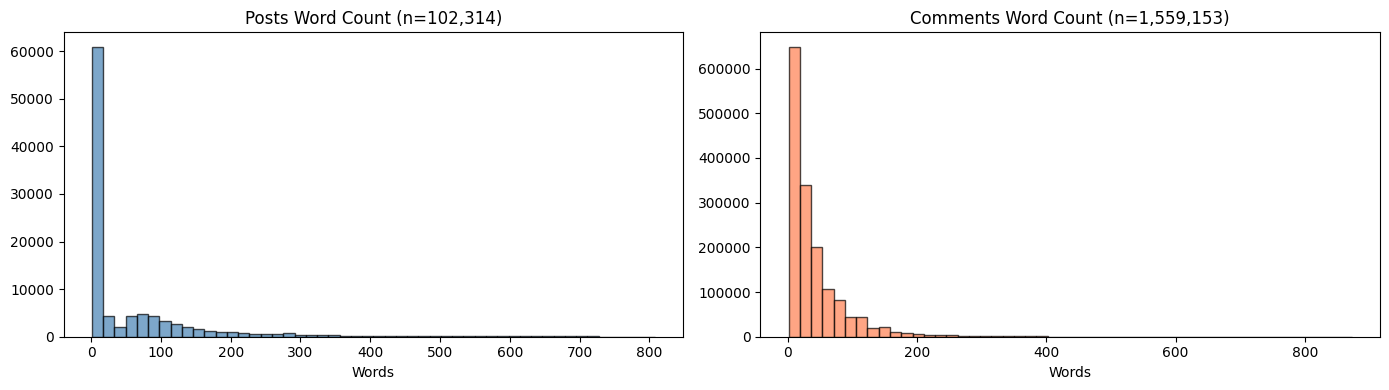


Texts ≤10 chars: 57,354 (3.5%)


In [13]:
valid_texts = df_unified[df_unified['text'].notna() & (df_unified['text'] != '')]
word_counts = valid_texts['text'].str.split().str.len()

print(f"Word count stats:")
print(f"  Mean: {word_counts.mean():.1f}")
print(f"  Median: {word_counts.median():.1f}")
print(f"  Min: {word_counts.min()}")
print(f"  Max: {word_counts.max()}")

posts = valid_texts[valid_texts['type'] == 'post']
comments = valid_texts[valid_texts['type'] == 'comment']

if len(posts) > 0 and len(comments) > 0:
    post_word_counts = posts['text'].str.split().str.len()
    comment_word_counts = comments['text'].str.split().str.len()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

    ax1.hist(post_word_counts, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
    ax1.set_title(f'Posts Word Count (n={len(posts):,})')
    ax1.set_xlabel('Words')

    ax2.hist(comment_word_counts, bins=50, edgecolor='black', alpha=0.7, color='coral')
    ax2.set_title(f'Comments Word Count (n={len(comments):,})')
    ax2.set_xlabel('Words')

    plt.tight_layout()
    plt.show()

text_lengths = valid_texts['text'].str.len()
very_short = (text_lengths <= MIN_TEXT_LENGTH).sum()
print(f"\nTexts ≤{MIN_TEXT_LENGTH} chars: {very_short:,} ({very_short/len(valid_texts)*100:.1f}%)")

**Distribution looks reasonable. Posts are longer than comments on average. For sentiment analysis, there's no concept of "outlier" in word count—all lengths are valid.**

### 5.5 Temporal Analysis

Analyze temporal distribution of posts/comments (daily/hourly patterns and date range).

Date range: 2024-01-01 00:00:09 to 2024-12-31 23:59:56
Span: 365 days


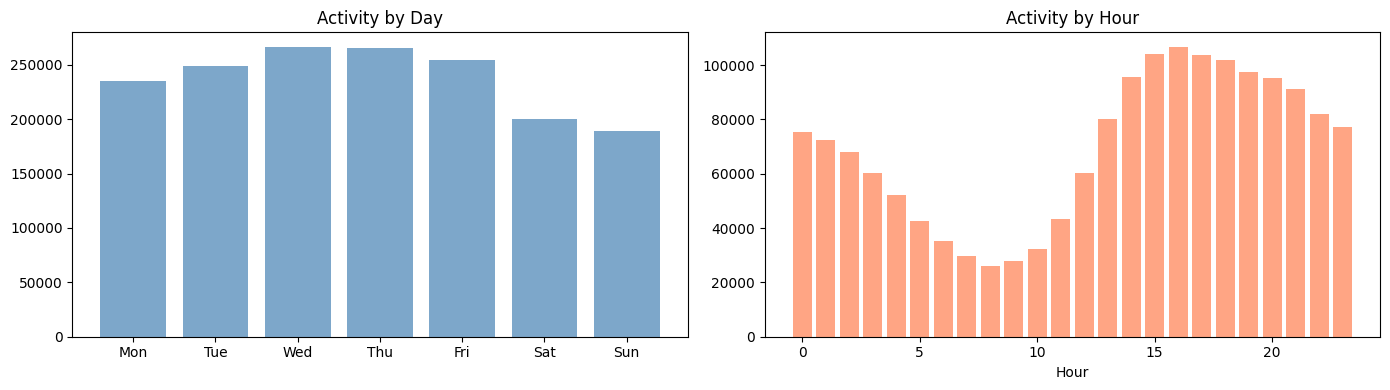

In [14]:
valid_dates = df_unified[df_unified['created_utc'].notna()].copy()
valid_dates['datetime'] = pd.to_datetime(valid_dates['created_utc'], unit='s')

print(f"Date range: {valid_dates['datetime'].min()} to {valid_dates['datetime'].max()}")
print(f"Span: {(valid_dates['datetime'].max() - valid_dates['datetime'].min()).days} days")

valid_dates['hour'] = valid_dates['datetime'].dt.hour
valid_dates['day_of_week'] = valid_dates['datetime'].dt.day_name()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_counts = valid_dates['day_of_week'].value_counts()
day_counts_ordered = [day_counts.get(d, 0) for d in day_order]
ax1.bar(range(7), day_counts_ordered, color='steelblue', alpha=0.7)
ax1.set_xticks(range(7))
ax1.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
ax1.set_title('Activity by Day')

hour_counts = valid_dates['hour'].value_counts()
hours = list(range(24))
counts = [hour_counts.get(h, 0) for h in hours]
ax2.bar(hours, counts, color='coral', alpha=0.7)
ax2.set_title('Activity by Hour')
ax2.set_xlabel('Hour')

plt.tight_layout()
plt.show()

**Peak activity: varies, but usually Wed/Thu, afternoon/evening hours.**

### 5.6 Upvote ratio analysis

Analyzujeme upvote_ratio - poměr kladných hodnocení (upvotes / (upvotes + downvotes)). Tato metrika je dostupná pouze pro posty.

Upvote ratio: mean=0.870, median=1.000


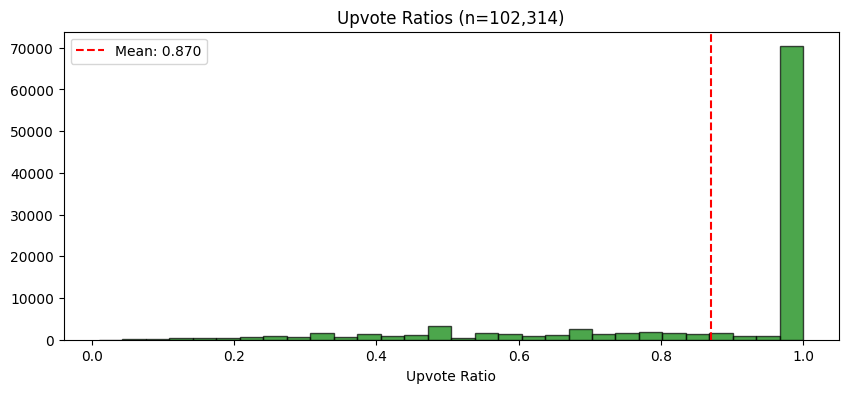

In [15]:
posts = df_unified[df_unified['type'] == 'post']
upvote_ratios = posts['upvote_ratio'].dropna()

print(f"Upvote ratio: mean={upvote_ratios.mean():.3f}, median={upvote_ratios.median():.3f}")

plt.figure(figsize=(10, 4))
plt.hist(upvote_ratios, bins=30, edgecolor='black', alpha=0.7, color='green')
plt.axvline(upvote_ratios.mean(), color='red', linestyle='--', label=f'Mean: {upvote_ratios.mean():.3f}')
plt.xlabel('Upvote Ratio')
plt.title(f'Upvote Ratios (n={len(upvote_ratios):,})')
plt.legend()
plt.show()

**Upvote ratio ranges 0-1, generally positive (mean ~0.9).**

### 5.7 Data Integrity & Duplicates

Check for duplicate IDs and other integrity issues (missing IDs, very short texts).

In [16]:
total_ids = len(df_unified)
unique_ids = df_unified['id'].nunique()
duplicate_ids = total_ids - unique_ids

print(f"Total rows: {total_ids:,}")
print(f"Unique IDs: {unique_ids:,}")
print(f"Duplicate IDs: {duplicate_ids:,}")

Total rows: 1,661,467
Unique IDs: 1,661,467
Duplicate IDs: 0


## 6 Data Cleaning

Remove deleted/empty texts, handle NAs, and filter out very short records.

In [17]:
before = len(df_unified)

df_cleaned = drop_invalid_texts(df_unified, min_len=MIN_TEXT_LENGTH)
df_cleaned = deduplicate_and_normalize_types(df_cleaned)

columns_to_drop = ['url', 'is_original_content', 'author']
existing_cols_to_drop = [col for col in columns_to_drop if col in df_cleaned.columns]
if existing_cols_to_drop:
    df_cleaned.drop(columns=existing_cols_to_drop, inplace=True)

print(f"Cleaned: {len(df_cleaned)} rows (removed {before - len(df_cleaned)})")

Cleaned: 1604113 rows (removed 57354)


## 7 Feature Engineering

Add useful features: text_length, word_count, temporal features, engagement features. Create normalized_upvotes (per subreddit, 0-1 scale). Drop original score column and upvote_ratio (only available for posts).

In [18]:
df_features = add_temporal_features(df_cleaned)
df_features = add_engagement_features(df_features)

if 'score' in df_features.columns and 'subreddit' in df_features.columns:
    df_features['normalized_upvotes'] = df_features.groupby('subreddit')['score'].transform(
        lambda x: (x - x.min()) / (x.max() - x.min() + 1e-6)
    )
    df_features.drop(columns=['score'], inplace=True)

if 'upvote_ratio' in df_features.columns:
    df_features.drop(columns=['upvote_ratio'], inplace=True)

print(f"Added features: {len(df_features)} rows")

/var/folders/33/r5z8ht2928103xc7s_sb_xx80000gq/T/ipykernel_4051/3916262446.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_features['normalized_upvotes'] = df_features.groupby('subreddit')['score'].transform(


Added features: 1604113 rows


## 8 Ticker Detection

Detect stock tickers in text using loaded ticker list. Store detected tickers in `mentioned_tickers` and count in `n_tickers`.

### 8.1 Detect Stock Ticker Mentions

In [19]:
df_with_tickers = apply_ticker_detection(df_features, tickers_df)

total_with_tickers = (df_with_tickers['n_tickers'] > 0).sum()
print(f"Rows with tickers: {total_with_tickers} / {len(df_with_tickers)} ({total_with_tickers/len(df_with_tickers)*100:.1f}%)")

100%|██████████| 1604113/1604113 [00:10<00:00, 159660.54it/s]


Rows with tickers: 246931 / 1604113 (15.4%)


### 8.2 Filter False Positive Tickers

In [20]:
ticker_stopwords = load_ticker_stopwords()
before_count = df_with_tickers['n_tickers'].sum()
df_with_tickers = apply_ticker_stopword_filter(df_with_tickers, ticker_stopwords)
after_count = df_with_tickers['n_tickers'].sum()

print(f"Filtered {before_count - after_count} false positives")

INFO:utils:Loaded 547 ticker stopwords
INFO:utils:After stopword filtering: 184329 rows with valid tickers


Filtered 89020 false positives


### 8.3 Ticker Inheritance — Comments Inherit Parent Post Tickers

Comments inherit tickers from their parent posts (union). This improves ticker coverage for comments that discuss a post without explicitly mentioning the ticker.

In [21]:
comments_before = df_with_tickers[df_with_tickers['type'] == 'comment'].copy()
comments_with_tickers_before = (comments_before['n_tickers'] > 0).sum()

posts = df_with_tickers[df_with_tickers['type'] == 'post'].copy()
post_ticker_map = {}

for _, row in posts.iterrows():
    post_id = row['id']
    tickers_data = row.get('mentioned_tickers', [])
    if isinstance(tickers_data, list) and len(tickers_data) > 0:
        post_ticker_map[post_id] = set(tickers_data)

def inherit_parent_tickers(row):
    if row['type'] == 'comment':
        parent_id = row.get('parent_post_id')
        if pd.notna(parent_id) and parent_id in post_ticker_map:
            own_tickers = set(row.get('mentioned_tickers', []))
            parent_tickers = post_ticker_map[parent_id]
            merged_tickers = own_tickers.union(parent_tickers)
            return sorted(merged_tickers)

    tickers_data = row.get('mentioned_tickers', [])
    return tickers_data if isinstance(tickers_data, list) else []

df_with_tickers['mentioned_tickers'] = df_with_tickers.apply(inherit_parent_tickers, axis=1)
df_with_tickers['n_tickers'] = df_with_tickers['mentioned_tickers'].apply(len)

print("Ticker inheritance complete")

Ticker inheritance complete


### 8.4 Ticker Inheritance Impact Analysis

In [22]:
posts = df_with_tickers[df_with_tickers['type'] == 'post']
comments = df_with_tickers[df_with_tickers['type'] == 'comment']

posts_with_tickers = (posts['n_tickers'] > 0).sum()
comments_with_tickers_after = (comments['n_tickers'] > 0).sum()

print(f"POSTS:")
print(f"  With tickers: {posts_with_tickers} / {len(posts)} ({posts_with_tickers/len(posts)*100:.1f}%)")

print(f"\nCOMMENTS:")
print(f"  BEFORE inheritance: {comments_with_tickers_before} / {len(comments)} ({comments_with_tickers_before/len(comments)*100:.1f}%)")
print(f"  AFTER inheritance:  {comments_with_tickers_after} / {len(comments)} ({comments_with_tickers_after/len(comments)*100:.1f}%)")
print(f"  Improvement: +{comments_with_tickers_after - comments_with_tickers_before} comments gained tickers")

total_with_tickers = (df_with_tickers['n_tickers'] > 0).sum()
print(f"\nOVERALL:")
print(f"  Total with tickers: {total_with_tickers} / {len(df_with_tickers)} ({total_with_tickers/len(df_with_tickers)*100:.1f}%)")

if 'parent_post_id' in df_with_tickers.columns:
    df_with_tickers.drop(columns=['parent_post_id'], inplace=True)

POSTS:
  With tickers: 18200 / 101934 (17.9%)

COMMENTS:
  BEFORE inheritance: 166129 / 1502179 (11.1%)
  AFTER inheritance:  502308 / 1502179 (33.4%)
  Improvement: +336179 comments gained tickers

OVERALL:
  Total with tickers: 520508 / 1604113 (32.4%)


### 8.5 Data Type Conversion

Ensure all columns have correct data types after feature engineering and ticker detection.

In [23]:
df_with_tickers['created_utc'] = pd.to_datetime(df_with_tickers['created_utc'])
df_with_tickers['date'] = pd.to_datetime(df_with_tickers['date'])
df_with_tickers['hour'] = df_with_tickers['hour'].astype('int8')
df_with_tickers['month'] = df_with_tickers['month'].astype('int8')
df_with_tickers['text_length'] = df_with_tickers['text_length'].astype('int32')
df_with_tickers['word_count'] = df_with_tickers['word_count'].astype('int32')
df_with_tickers['n_tickers'] = df_with_tickers['n_tickers'].astype('int16')
df_with_tickers['is_weekend'] = df_with_tickers['is_weekend'].astype('bool')
df_with_tickers['day_of_week'] = df_with_tickers['day_of_week'].astype('category')
df_with_tickers['type'] = df_with_tickers['type'].astype('category')
df_with_tickers['subreddit'] = df_with_tickers['subreddit'].astype('category')
df_with_tickers['normalized_upvotes'] = df_with_tickers['normalized_upvotes'].astype('float32')

print("Data types converted")

Data types converted


## 9 Text Normalization for FinBERT

Light normalization for transformer models. FinBERT and similar models work best with natural text, so we only do minimal cleaning: remove URLs and extra whitespace. We keep punctuation, capitalization, and all words because these contain important sentiment signals.

**Note:** We use the `normalize_text_for_sentiment()` function from utils.py which applies light normalization (URLs and whitespace only).

In [24]:
df_final = df_with_tickers.copy()
df_final['sentiment_ready_text'] = df_final['text'].apply(normalize_text_for_sentiment)

print(f"Text normalized: {len(df_final)} rows")

Text normalized: 1604113 rows


**Final check: Drop original text column, keep only rows with at least one ticker. The sentiment_ready_text preserves natural language for FinBERT.**

In [25]:
df_final.drop(columns=['text'], inplace=True)
df_final = df_final[df_final['n_tickers'] > 0].reset_index(drop=True)
print(f"Final dataset: {len(df_final)} rows with tickers")
display(df_final.head(10))

Final dataset: 520508 rows with tickers


,created_utc,id,subreddit,type,date,hour,day_of_week,month,is_weekend,text_length,word_count,normalized_upvotes,mentioned_tickers,n_tickers,sentiment_ready_text
0,2024-12-31 23:24:29,1hqqmq2,stocks,post,2024-12-31,23,Tuesday,12,False,476,82,0.078138,[SOUN],1,soundhound $SOUN NOW HAS a market CAP 75x IT s...
1,2024-12-31 23:15:10,1hqqgv5,stocks,post,2024-12-31,23,Tuesday,12,False,419,75,0.050911,[SMCI],1,IS $SMCI beginning TO BE a PLAY p e IS looking...
2,2024-12-31 22:45:36,1hqpxkb,investing,post,2024-12-31,22,Tuesday,12,False,42,6,0.123091,[RDDT],1,ANY thoughts ON RDDT feedback appreciated
3,2024-12-31 22:43:25,1hqpw3r,ValueInvesting,post,2024-12-31,22,Tuesday,12,False,391,75,0.054083,[DHI],1,IS d r horton DHI GOOD VALUE THE STOCK IS DOWN...
4,2024-12-31 22:27:23,1hqplbe,stocks,post,2024-12-31,22,Tuesday,12,False,17,3,0.050911,[RDDT],1,thoughts ON RDDT
5,2024-12-31 21:57:03,1hqp0ms,investing,post,2024-12-31,21,Tuesday,12,False,337,62,0.123091,[QQQ],1,seeking STOCK market guidance SORRY IF THIS qu...
6,2024-12-31 21:46:30,1hqote4,investing,post,2024-12-31,21,Tuesday,12,False,762,148,0.123091,[RH],1,question ABOUT margin trading IN robinhood acc...
7,2024-12-31 21:32:48,1hqok2f,ValueInvesting,post,2024-12-31,21,Tuesday,12,False,440,78,0.054083,[QQQ],1,WHAT IS YOUR investing NEW YEAR s resolution M...
8,2024-12-31 20:51:29,1hqnqpl,stocks,post,2024-12-31,20,Tuesday,12,False,4080,544,0.050911,[ANIX],1,trying something NEW chaptgpt review OF specul...
9,2024-12-31 20:35:25,1hqnf5w,ValueInvesting,post,2024-12-31,20,Tuesday,12,False,1421,247,0.123310,"[BABA, BIDU, DB, DG, NVO, WBD]",6,stocks i m buying FOR 2025 TLDR stocks i m buy...


## 10 Export Results

Save final dataset with preprocessed text and features to CSV.

In [26]:
export_df = df_final.copy()

export_df = export_df[export_df['sentiment_ready_text'].notna() & (export_df['sentiment_ready_text'] != '')].reset_index(drop=True)

export_df['mentioned_tickers'] = export_df['mentioned_tickers'].apply(
    lambda x: ','.join(x) if isinstance(x, list) else ''
)
# Convert day_of_week to numeric (0=Monday, 6=Sunday)
day_mapping = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6}
export_df['day_of_week'] = export_df['day_of_week'].map(day_mapping)

export_df.to_csv("outputs/preprocessed_data.csv", index=False)
print(f"Exported {len(export_df)} rows to CSV")

Exported 520497 rows to CSV


## 11 Database Export — Oracle

Export preprocessed data to Oracle table `preprocessed_data` for sentiment analysis.

In [27]:
conn = get_oracle_connection()

if conn:
    cursor = conn.cursor()
    cursor.execute("TRUNCATE TABLE preprocessed_data")

    # Rename 'date' to 'date_col' for Oracle compatibility
    db_export_df = export_df.copy()
    if 'date' in db_export_df.columns:
        db_export_df.rename(columns={'date': 'date_col'}, inplace=True)

    # Build INSERT statement
    cols = ['id', 'sentiment_ready_text', 'type', 'subreddit', 'created_utc', 'normalized_upvotes',
            'mentioned_tickers', 'n_tickers', 'text_length', 'word_count', 'date_col', 'hour', 'day_of_week']
    oracle_cols = [c.upper() for c in cols if c in db_export_df.columns]
    placeholders = ', '.join([f':{i+1}' for i in range(len(oracle_cols))])
    insert_sql = f"INSERT INTO preprocessed_data ({', '.join(oracle_cols)}) VALUES ({placeholders})"

    # Prepare data
    insert_data = []
    for _, row in db_export_df.iterrows():
        row_data = []
        for col in [c for c in cols if c in db_export_df.columns]:
            if col == 'created_utc':
                row_data.append(row[col].timestamp() if pd.notna(row[col]) else None)
            elif col in ['n_tickers', 'text_length', 'word_count', 'hour', 'day_of_week']:
                row_data.append(int(row[col]) if pd.notna(row[col]) else None)
            elif col == 'normalized_upvotes':
                row_data.append(float(row[col]) if pd.notna(row[col]) else None)
            elif col == 'date_col':
                row_data.append(row[col] if pd.notna(row[col]) else None)
            else:
                row_data.append(str(row[col]) if pd.notna(row[col]) else '')
        insert_data.append(tuple(row_data))

    cursor.executemany(insert_sql, insert_data)
    conn.commit()
    cursor.close()
    conn.close()

    print(f"Exported {len(insert_data)} rows to Oracle")
else:
    print("Database connection failed")

Oracle connection successful!
Exported 520497 rows to Oracle
